In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm
import torch
from scipy.stats import pearsonr
from umap import UMAP
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR  
import deer.controllers as bc 
import yaml
from scipy.stats import pearsonr
from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy
from deer.environments.Figure8 import MyEnv as Env

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
from deer.environments.Figure8 import MyEnv as Env

# Helper functions

In [3]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

In [134]:
def plotA(
    df, plot_key, plot_epoch,
    fnames=None, figname=None,
    smooth_line=True, smooth_n=5, smooth_plot=True, colors=None,
    legend_title='Auxiliary Task'):
    
    fig, ax = plt.subplots(figsize=(2.1, 1.5))
    zs = np.sort(np.unique(df['z']))
    epochs = np.sort(np.unique(df['epochs']))
    if fnames is None:
        fnames = np.unique(df['fname'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            means = []
            sems = []
            df_subset = df[(df['fname']==fname) & (df['z']==z)]
            for epoch in epochs:
                vals = df_subset[df_subset['epochs']==epoch]
                vals = vals[plot_key]
                means.append(np.mean(vals))
                sems.append(sem(vals))
            means = np.array(means)
            sems = np.array(sems)
            mean_lowerbound = means - sems
            mean_upperbound = means + sems
            if smooth_line:
                means = smooth(epochs, means, smooth_n)
                mean_lowerbound = smooth(epochs, mean_lowerbound)
                mean_upperbound = smooth(epochs, mean_upperbound)
            line.append(means[plot_epoch])
            shading_lower.append(mean_lowerbound[plot_epoch])
            shading_upper.append(mean_upperbound[plot_epoch])
        if smooth_plot:
            _line = smooth(zs, line, 2)
            _shading_lower = smooth(zs, shading_lower, 2)
            _shading_upper = smooth(zs, shading_upper, 2)
            _line[0] = line[0]; _line[-1] = line[-1]
            _shading_lower[0] = shading_lower[0]
            _shading_lower[-1] = shading_lower[-1]
            _shading_upper[0] = shading_upper[0]
            _shading_upper[-1] = shading_upper[-1]
            line = _line; shading_lower = _shading_lower;
            shading_uppper = _shading_upper
        x_axis = zs#/26
        if colors is not None:
            color = colors[fname_idx]
        if fname == '10':
            label = 'Predictive'
        elif fname == 'No Aux. Task':
            label = 'MF Only'
        else:
            label = None
        ax.plot(x_axis, line, label=label, color=color)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.4,color=color)
    plt.ylabel('Test Score', fontsize=10)
    plt.xlabel('Latent Dimension', fontsize=10)
    #plt.legend(title=None, fontsize=7)
    plt.ylim(-0.05, 1.05)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

# 1. Foraging Task A Results

In [132]:
transfer_data = {
    'performance': [], 'dims': [], 'epochs': [],
    'fname': [], 'z': [], 'steps': []
    }
for z in zs:
    transfer_dir = f'ccn_Tsweep_dm_dim{z}'
    #transfer_dir = f'frozentransfer_foragingT2_dm_dim{z}'
    transfer_dir = f'{engram_dir}pickles/{transfer_dir}/'
    if not os.path.exists(transfer_dir):
        continue
    for pickle_file in os.listdir(transfer_dir):
        pickle_file = f'{transfer_dir}{pickle_file}'
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_scores = results['valid_scores']
        valid_steps = results['valid_steps']
        dimensionality_tracking = results['dimensionality_tracking']
        fnames = results['fname']
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        multiple = int(n_fname/n_scores)
        for idx in range(n_scores):
            perf = valid_scores[idx]
            steps = valid_steps[idx]
            dim = dimensionality_tracking[idx]
            fname = fnames[idx*multiple]
            if fname.endswith('_10'):
                fname = '10'
            elif '_8' in fname:
                fname = '8'
            elif 'mf' in fname:
                fname = 'No Aux. Task'
            elif '_4' in fname:
                fname = '4'
            elif '_2' in fname:
                fname = '2'
            elif '_1' in fname:
                fname = '1'
            for epoch in range(len(perf)):
                transfer_data['performance'].append(perf[epoch])
                transfer_data['steps'].append(steps[epoch])
                transfer_data['dims'].append(dim)
                transfer_data['epochs'].append(epoch)
                transfer_data['fname'].append(fname)
                transfer_data['z'].append(z)
taskA_df = pd.DataFrame(transfer_data)

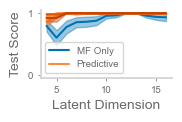

In [133]:
colors = cm.get_cmap('Oranges')
color_steps = np.linspace(0.4, 0.8, 5, endpoint=True)
plotA(taskA_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['No Aux. Task', '1', '10', '2', '4', '8'],
      smooth_plot=False,
      figname='decodersize_late', legend_title='Learning',
      colors = ['C0'] + [colors(i) for i in color_steps]
     )

# 2. Foraging Task B Results

In [4]:
zs = np.arange(4, 18)

In [19]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
engram_dir = '/Volumes/aronov-locker/Ching/rl/'

In [20]:
transfer_data = {
    'performance': [], 'dims': [], 'epochs': [],
    'fname': [], 'z': [], 'steps': []
    }
for z in zs:
    transfer_dir = f'frozentransfer_ccn_Tsweep_dm_dim{z}'
    #transfer_dir = f'frozentransfer_foragingT2_dm_dim{z}'
    transfer_dir = f'{engram_dir}pickles/{transfer_dir}/'
    if not os.path.exists(transfer_dir):
        continue
    for pickle_file in os.listdir(transfer_dir):
        pickle_file = f'{transfer_dir}{pickle_file}'
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_scores = results['valid_scores']
        valid_steps = results['valid_steps']
        dimensionality_tracking = results['dimensionality_tracking']
        fnames = results['fname']
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        multiple = int(n_fname/n_scores)
        for idx in range(n_scores):
            perf = valid_scores[idx]
            steps = valid_steps[idx]
            dim = dimensionality_tracking[idx]
            fname = fnames[idx*multiple]
            if fname.endswith('_10'):
                fname = '10'
            elif '_8' in fname:
                fname = '8'
            elif 'mf' in fname:
                fname = 'No Aux. Task'
            elif '_4' in fname:
                fname = '4'
            elif '_2' in fname:
                fname = '2'
            elif '_1' in fname:
                fname = '1'
            for epoch in range(len(perf)):
                transfer_data['performance'].append(perf[epoch])
                transfer_data['steps'].append(steps[epoch])
                transfer_data['dims'].append(dim)
                transfer_data['epochs'].append(epoch)
                transfer_data['fname'].append(fname)
                transfer_data['z'].append(z)
transfer_df = pd.DataFrame(transfer_data)

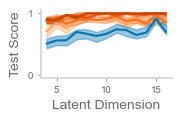

In [135]:
colors = cm.get_cmap('Oranges')
color_steps = np.linspace(0.4, 0.8, 5, endpoint=True)
plotA(transfer_df, 'performance', 38, smooth_line=True, smooth_n=2,
      fnames=['1', '10', '2', '4', '8', 'No Aux. Task'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors = [colors(i) for i in color_steps] + ['C0']
     )

# 3. Alternating-T Split Correlation Plots

In [9]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
#engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

internal_dim = 7
generic_exp_name = 'noisy_altT_eps0.5_volweight'

internal_dim = 16
generic_exp_name = 'ccn_fig8_eps0.75'

test_noise = 0.

exp_name = f'{generic_exp_name}_dm_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'

In [ ]:
corr = []
stem_loc = []
score = []
model = []
full_id = []
for model_name in os.listdir(nnets_dir):
    if 'fig8' not in model_name: continue
    fname = f'{generic_exp_name}_mf' if 'mf' in model_name else f'{generic_exp_name}_1'
    with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp_name}/{model_name}'
    parameters['internal_dim'] = internal_dim
    env = Env(                                                                     
        give_rewards=parameters['figure8_give_rewards'],                           
        higher_dim_obs=parameters['higher_dim_obs'],                               
        show_rewards=parameters['show_rewards'], plotfig=False,
        obs_noise=test_noise
        ) 
    rng = np.random.RandomState()
    learning_algo = CRAR(                                                          
        env, parameters['freeze_interval'], parameters['batch_size'], rng,         
        internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
        nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
        double_Q=True, loss_weights=parameters['loss_weights'],                    
        encoder_type=parameters['encoder_type'], mem_len=parameters['mem_len'],
        train_len=parameters['train_len']  
        )   
    train_policy = EpsilonGreedyPolicy(                                     
        learning_algo, env.nActions(), rng, epsilon=1.)             
    test_policy = EpsilonGreedyPolicy(                                      
        learning_algo, env.nActions(), rng, 0.)  
    agent = NeuralAgent(                                                        
        env, learning_algo, parameters['replay_memory_size'], 1,                
        parameters['batch_size'], rng, save_dir=engram_dir,                     
        train_policy=train_policy, test_policy=test_policy)
    agent.attach(bc.LearningRateController(                                     
        initial_learning_rate=parameters['learning_rate'],                      
        learning_rate_decay=parameters['learning_rate_decay'],                  
        periodicity=1))                                                         
    agent.attach(bc.TrainerController(                                          
        evaluate_on='action',  periodicity=parameters['update_frequency'],      
        show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
    best_controller = bc.FindBestController(                                    
        validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
    agent.attach(best_controller)                                               
    agent.attach(bc.InterleavedTestEpochController(                             
        id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
        periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))
    try:
        agent.setNetwork(parameters['fname'] + '/fname', nEpoch=60)
    except:
        print(f'Skipping {model_name}')

    agent._in_episode = True
    agent._mode = 0 # Testing mode with plan_depth=0
    initState = env.reset(agent._mode)
    inputDims = env.inputDimensions()
    for i in range(len(inputDims)):
        if inputDims[i][0] > 1:
            agent._state[i][1:] = initState[i][1:]
    agent._Vs_on_last_episode = []
    is_terminal = False
    reward = 0

    xs = []
    ys = []
    latents = []
    reward_locs = []
    for i in range(100):
        obs = env.observe()
        for i in range(len(obs)):
            agent._state[i] = obs[i]    

            state = torch.as_tensor(agent._state).float()
            zs = torch.as_tensor(agent._latent).float()
            latent = agent._learning_algo.crar.encoder(state, zs=zs)
            latent = latent.detach().cpu().numpy()
            loc = list(np.unravel_index(
                np.argmax(obs[i]), obs[i].shape))
            xs.append(loc[0]-1)
            ys.append(loc[1]-1)
            latents.append(latent)
            reward_locs.append(env._reward_location)
            agent._latent[0, 0:-1] = agent._latent[0, 1:]
            agent._latent[0, -1] = latent

        V, action, reward_received = agent._step()
        reward += reward_received
        agent._Vs_on_last_episode.append(V)
        is_terminal = env.inTerminalState()
        if is_terminal: break     
    xs = np.array(xs)
    ys = np.array(ys)
    latents = np.array(latents).squeeze()
    reward_locs = np.array(reward_locs)
    
    # Record results
    midwidth = env.WIDTH//2
    for y in range(4):
        idxs = np.logical_and(xs==midwidth, ys==y)
        right_idxs = np.logical_and(idxs, reward_locs==env.RIGHT_REWARD)
        left_idxs = np.logical_and(idxs, reward_locs==env.LEFT_REWARD)
        try:
            _corr = pearsonr(
                np.mean(latents[right_idxs], axis=0),
                np.mean(latents[left_idxs], axis=0))[0]
            _corr = abs(_corr)
        except Exception as e:
            continue
        corr.append(_corr)
        stem_loc.append(y)
        score.append(reward)
        model.append(fname)
        full_id.append(model_name)

In [56]:
%matplotlib inline
df = pd.DataFrame({
    'score': score, 'corr': corr, 'model': model, 'stem_loc': stem_loc,
    'full_id': full_id
    })

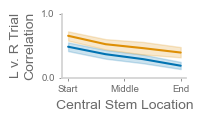

In [48]:
fig, ax = plt.subplots(figsize=(2.25, 1.5))
sns.lineplot(
    x='stem_loc', y='corr', hue='model',
    ax=ax, legend=None,
    data=df[df['score']>=18],
    )
ax.set_ylabel(
    'L v. R Trial\nCorrelation',
    fontsize=10)
ax.set_xlabel(
    'Central Stem Location', fontsize=10
    )
ax.set_yticks(
    [0.,1.], [0.,1.], fontsize=7)
ax.set_xticks(
    [0.,1.5, 3.], ['Start', 'Middle', 'End'],
    fontsize=7)
ax.set_ylim(0,1.)
plt.tight_layout()
plt.savefig('split.png', dpi=300)

# 4. Alternating-T 3D UMAP Plots

In [6]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
#engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
internal_dim = 16
generic_exp_name = 'ccn_fig8_eps0.75' #'noisy_altT_eps0.5_volweight' #'noisy_altT'
exp_name = f'{generic_exp_name}_dm_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'

In [20]:
np.random.seed(0)

ccn_fig8_eps0.75_1_7


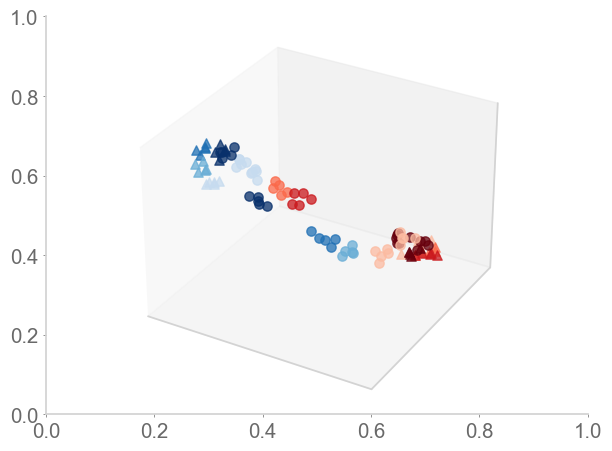

ccn_fig8_eps0.75_1_30
ccn_fig8_eps0.75_mf_0
ccn_fig8_eps0.75_1_14
ccn_fig8_eps0.75_1_20


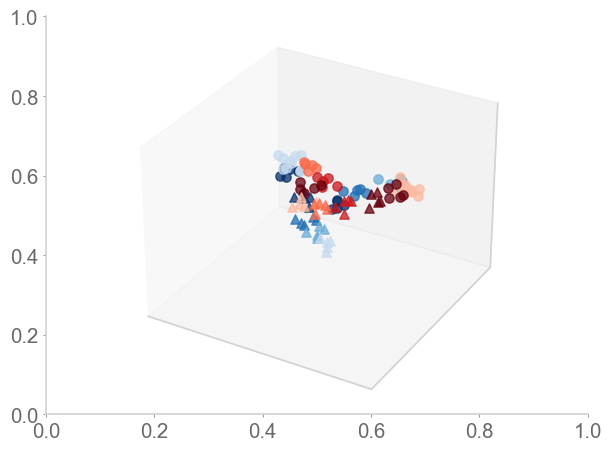

ccn_fig8_eps0.75_1_9
ccn_fig8_eps0.75_1_4


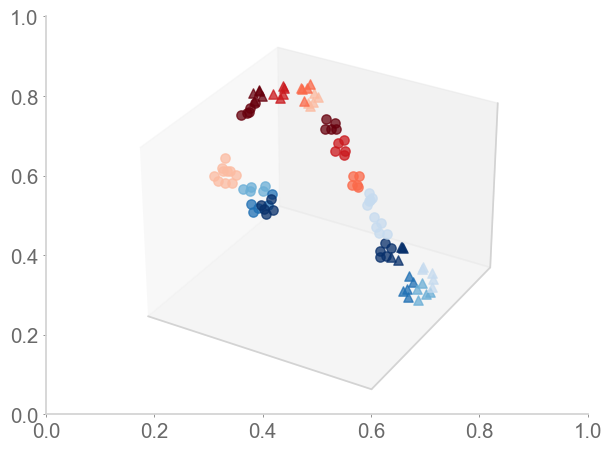

ccn_fig8_eps0.75_1_29
ccn_fig8_eps0.75_1_21
ccn_fig8_eps0.75_mf_11
ccn_fig8_eps0.75_mf_27
ccn_fig8_eps0.75_mf_24
ccn_fig8_eps0.75_1_23


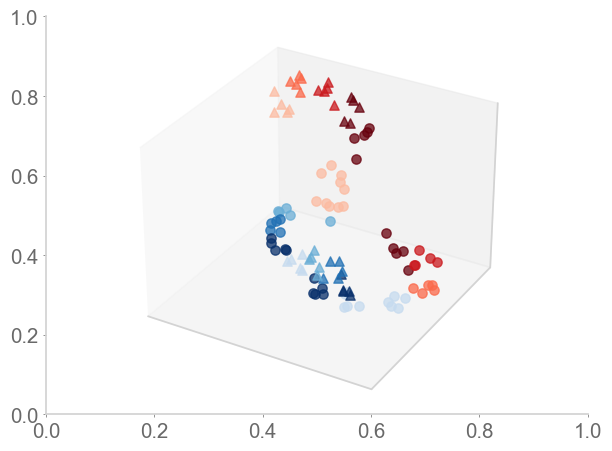

ccn_fig8_eps0.75_1_12
ccn_fig8_eps0.75_mf_26
ccn_fig8_eps0.75_mf_25
.DS_Store
ccn_fig8_eps0.75_mf_4
ccn_fig8_eps0.75_1_15
ccn_fig8_eps0.75_1_16
ccn_fig8_eps0.75_1_24
ccn_fig8_eps0.75_mf_28


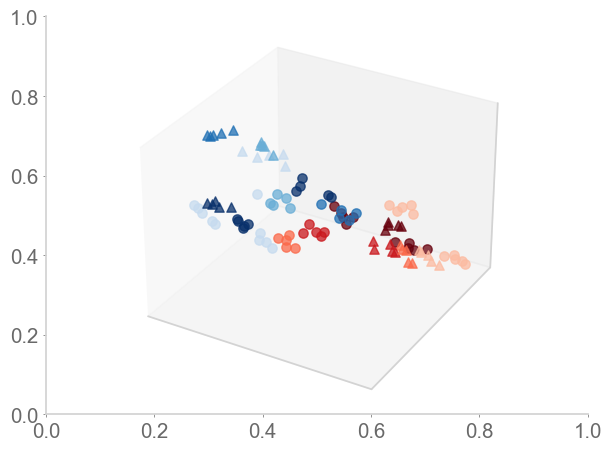

ccn_fig8_eps0.75_mf_15
ccn_fig8_eps0.75_mf_6
ccn_fig8_eps0.75_1_5
ccn_fig8_eps0.75_mf_23
ccn_fig8_eps0.75_1_22


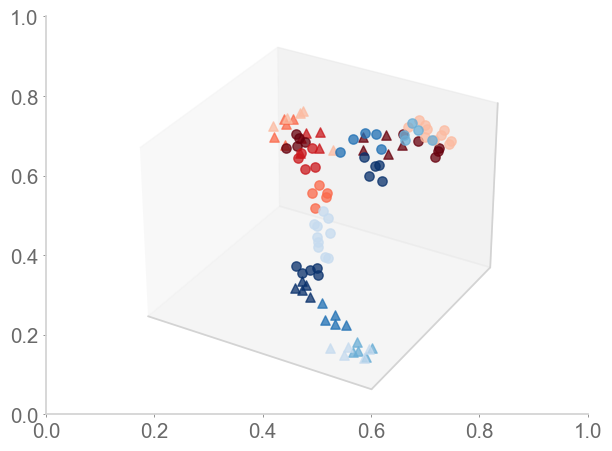

ccn_fig8_eps0.75_mf_19
ccn_fig8_eps0.75_1_13
ccn_fig8_eps0.75_mf_1
ccn_fig8_eps0.75_1_31
ccn_fig8_eps0.75_mf_13
ccn_fig8_eps0.75_1_11
ccn_fig8_eps0.75_mf_7
ccn_fig8_eps0.75_mf_21
ccn_fig8_eps0.75_mf_31
ccn_fig8_eps0.75_mf_18


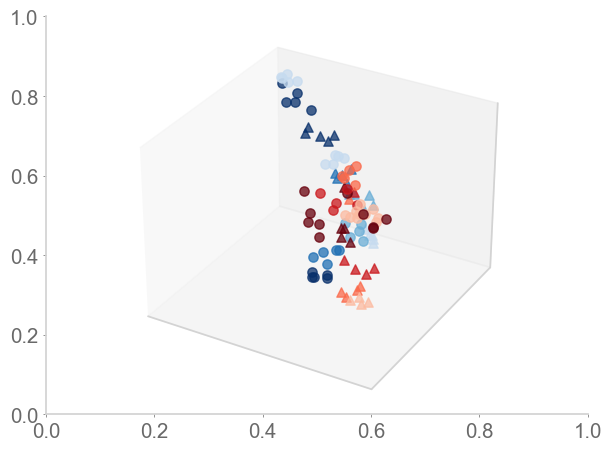

ccn_fig8_eps0.75_1_27
ccn_fig8_eps0.75_mf_22
ccn_fig8_eps0.75_mf_10
ccn_fig8_eps0.75_mf_17
ccn_fig8_eps0.75_1_18
ccn_fig8_eps0.75_mf_30
ccn_fig8_eps0.75_mf_9
ccn_fig8_eps0.75_mf_20
ccn_fig8_eps0.75_mf_3
ccn_fig8_eps0.75_mf_16
ccn_fig8_eps0.75_1_0


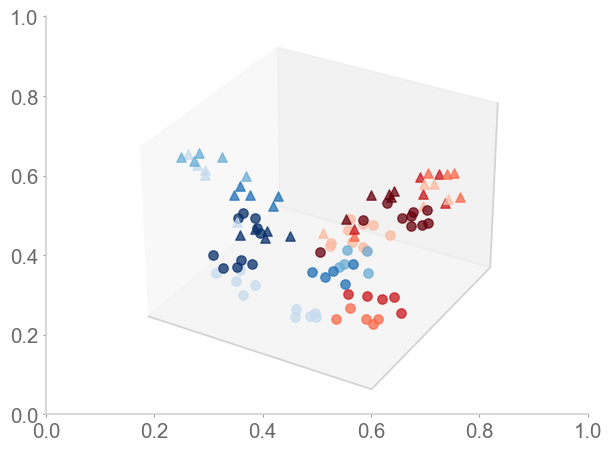

ccn_fig8_eps0.75_1_28
ccn_fig8_eps0.75_1_25
ccn_fig8_eps0.75_1_17
ccn_fig8_eps0.75_mf_29
ccn_fig8_eps0.75_1_3
ccn_fig8_eps0.75_1_6
ccn_fig8_eps0.75_mf_5
ccn_fig8_eps0.75_1_10
ccn_fig8_eps0.75_mf_2
ccn_fig8_eps0.75_1_19
ccn_fig8_eps0.75_1_8


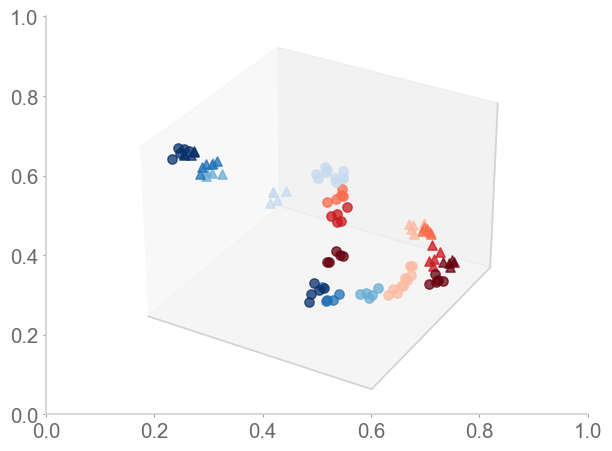

ccn_fig8_eps0.75_mf_8
ccn_fig8_eps0.75_mf_12
ccn_fig8_eps0.75_1_1
ccn_fig8_eps0.75_1_2
ccn_fig8_eps0.75_mf_14
ccn_fig8_eps0.75_1_26


In [54]:
corr = []
stem_loc = []
score = []
model = []
for model_name in os.listdir(nnets_dir):
    print(model_name)
    if 'fig8' not in model_name: continue
    fname = f'{generic_exp_name}_mf' if 'mf' in model_name else f'{generic_exp_name}_1'
    #fname = f'noisy_altT_mb' if 'mb' in model_name else f'noisy_altT_mf'
    
    with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp_name}/{model_name}'
    parameters['internal_dim'] = internal_dim
    env = Env(                                                                     
        give_rewards=parameters['figure8_give_rewards'],                           
        higher_dim_obs=parameters['higher_dim_obs'],                               
        show_rewards=parameters['show_rewards'], plotfig=False,
        obs_noise=1.
        )
    midwidth = env.WIDTH//2
    rng = np.random.RandomState()
    learning_algo = CRAR(                                                          
        env, parameters['freeze_interval'], parameters['batch_size'], rng,         
        internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
        nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
        double_Q=True, loss_weights=parameters['loss_weights'],                    
        encoder_type=parameters['encoder_type'], mem_len=parameters['mem_len'],
        train_len=parameters['train_len']  
        )   
    train_policy = EpsilonGreedyPolicy(                                     
        learning_algo, env.nActions(), rng, epsilon=1.)             
    test_policy = EpsilonGreedyPolicy(                                      
        learning_algo, env.nActions(), rng, 0.)  
    agent = NeuralAgent(                                                        
        env, learning_algo, parameters['replay_memory_size'], 1,                
        parameters['batch_size'], rng, save_dir=engram_dir,                     
        train_policy=train_policy, test_policy=test_policy)
    agent.attach(bc.LearningRateController(                                     
        initial_learning_rate=parameters['learning_rate'],                      
        learning_rate_decay=parameters['learning_rate_decay'],                  
        periodicity=1))                                                         
    agent.attach(bc.TrainerController(                                          
        evaluate_on='action',  periodicity=parameters['update_frequency'],      
        show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
    best_controller = bc.FindBestController(                                    
        validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
    agent.attach(best_controller)                                               
    agent.attach(bc.InterleavedTestEpochController(                             
        id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
        periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))
    try:
        agent.setNetwork(parameters['fname'] + '/fname', nEpoch=60)
    except:
        print(f'Skipping {model_name}')

    agent._in_episode = True
    agent._mode = 0 # Testing mode with plan_depth=0
    initState = env.reset(agent._mode)
    inputDims = env.inputDimensions()
    for i in range(len(inputDims)):
        if inputDims[i][0] > 1:
            agent._state[i][1:] = initState[i][1:]
    agent._Vs_on_last_episode = []
    is_terminal = False
    reward = 0

    xs = []
    ys = []
    latents = []
    reward_locs = []
    for i in range(100):
        obs = env.observe()
        for i in range(len(obs)):
            agent._state[i] = obs[i]    

            state = torch.as_tensor(agent._state).float()
            zs = torch.as_tensor(agent._latent).float()
            latent = agent._learning_algo.crar.encoder(state, zs=zs)
            latent = latent.detach().cpu().numpy()
            loc = list(np.unravel_index(
                np.argmax(obs[i]), obs[i].shape))
            xs.append(loc[0]-1)
            ys.append(loc[1]-1)
            latents.append(latent)
            reward_locs.append(env._reward_location)
            agent._latent[0, 0:-1] = agent._latent[0, 1:]
            agent._latent[0, -1] = latent

        V, action, reward_received = agent._step()
        reward += reward_received
        agent._Vs_on_last_episode.append(V)
        is_terminal = env.inTerminalState()
        if is_terminal: break     
    xs = np.array(xs)
    ys = np.array(ys)
    latents = np.array(latents).squeeze()
    reward_locs = np.array(reward_locs)
    if reward < 20: continue
    
    reducer = UMAP(
        n_neighbors=20, n_components=3, metric='euclidean',
        n_epochs=1000, learning_rate=1.0,
        min_dist=0.2)
    reduced_latents = reducer.fit_transform(latents)
    
    %matplotlib inline
    fig, ax = plt.subplots()
    ax = fig.add_subplot(111,projection='3d')  # 3d
    colors = [cm.get_cmap('Reds'), cm.get_cmap('Blues'), cm.get_cmap('Blues')]
    color_steps = np.linspace(0.25, 1., env.HEIGHT, endpoint=True)
    markers = ['s', '^', 'o']
    for i in np.arange(reduced_latents.shape[0]):
        condn_label = env._space_label[xs[i], ys[i]]
        if condn_label == 0: # Decision point
            color_step = color_steps[ys[i]]
            color = colors[reward_locs[i]](color_step)
            marker = '^'
        elif (reward_locs[i]<2) and (xs[i]==midwidth):
            color_step = color_steps[ys[i]]
            color = colors[reward_locs[i]](color_step)
            marker = '^'
        elif xs[i] < midwidth:
            color_step = color_steps[ys[i]]
            if ys[i] == 0:
                color = colors[1](color_step)
            else:
                color = colors[0](color_step)
            marker = 'o'
        elif xs[i] > midwidth:
            color_step = color_steps[ys[i]]
            if ys[i] == 0:
                color = colors[0](color_step)
            else:
                color = colors[1](color_step)
            marker = 'o'
        else:
            print('error')
        ax.scatter(
            reduced_latents[i,0], reduced_latents[i,1], reduced_latents[i,2],
            color=color,
            marker=marker, #edgecolors='k',
            alpha=0.75, s=45
            )
    plt.xticks([]);plt.yticks([])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.tight_layout()
    plt.savefig(model_name + '.png', dpi=300)
    plt.show()